Test out a log version of the best-fit curve

In [1]:
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import numpy as np
from lmfit import minimize, Parameters
import pandas as pd
#import richardsplot as rplot
from astropy.table import Table
from sklearn.preprocessing import scale, MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
sys.path.append('/Users/Trevor1/Desktop/git/CIV_Distance')
from CIVfunctions import project,CIV_distance

In [3]:
! ls /Users/Trevor1/Desktop/data/files/catalogs

DR14Q_v4_4.fits                        Rankine20_CIV_HeII_wDelGI.fits
DR16Q_v4.fits                          Rankine20_CIV_HeII_wDelGI_wCIVDist.csv
DR16Q_v4.short.csv.wrelgi              dr7_bh_May09_2011.fits
Rankine20_CIV_HeII.fits


In [4]:
df = Table.read('/Users/Trevor1/Desktop/data/files/catalogs/Rankine20_CIV_HeII_wDelGI.fits', format='fits')
names = [name for name in df.colnames if len(df[name].shape) <= 1] #skip multi-dimensional columns - don't need any of them yet anyway
dat = df[names].to_pandas()
dat.head()

,SDSS_NAME,RA,Dec,z_paul,good,nBAL,AIi,BIi,CIV_blue,CIV_EW,...,FLUX_0.2_12.0keV_ERR,LUM_0.2_12.0keV,FUV,FUV_IVAR,NUV,NUV_IVAR,FIRST_FLUX,FIRST_SNR,Delta_G_I,Separation
0,b'003708.46+002855.8',9.285266,0.482174,3.02295,True,False,False,True,691.966469,75.072475,...,NaN,NaN,0.032006,45.552314,-0.018692,3.531072,-1.0,-1.0,0.600,0.000000e+00
1,b'004959.24+001903.1',12.496858,0.317540,3.32150,True,False,False,True,857.180965,32.148782,...,NaN,NaN,-0.079175,12.024832,-0.040529,3.323599,-1.0,-1.0,0.375,1.144982e-11
2,b'015017.70+002902.4',27.573786,0.484025,3.00333,True,False,False,True,1474.865400,31.916310,...,NaN,NaN,-0.068240,1074.827534,0.183702,373.859257,-1.0,-1.0,0.167,2.289918e-11
3,b'023238.49-001936.2',38.160390,-0.326749,3.34348,True,False,False,True,715.316626,40.857802,...,NaN,NaN,-0.042674,229.386872,0.313899,1.875008,-1.0,-1.0,0.831,0.000000e+00
4,b'072047.82+405455.5',110.199280,40.915418,3.04179,True,False,False,True,195.093283,106.332340,...,NaN,NaN,-0.394990,7.126986,0.070899,32.722264,-1.0,-1.0,-0.159,0.000000e+00


In [5]:
!ls /Users/Trevor1/Desktop/git/CIV_Distance/data

LOFAR_from8403colorselected_all388_CIV.csv
LOFAR_from8403colorselected_detections123_1arcsec.csv
RM_CIV_bestFitLine_noScale.npy
bestfit.npy


In [6]:
z = dat[["z_paul"]].values.flatten()
blue = dat[["CIV_blue"]].values.flatten()
EW   = dat[["CIV_EW"]].values.flatten()
logEW= np.log10(EW)
mask = (~np.isnan(logEW))&(~np.isinf(logEW)) #Need to mask -EW objects (nan and -inf)
EW_HeII = dat[["HeII_EW"]].values.flatten()
D_GI = dat[["Delta_G_I"]].values.flatten()
good = dat[["good"]].values.flatten()
MI   = dat[["MI"]].values.flatten()
d    = 3.08e19 #cm
L2500= -0.4 * ( MI + 48.60 + 2.5*np.log10(1.+2) ) + np.log10(4*np.pi*(d**2))

c4data_lin = np.array([blue, EW]).T
c4data_log = np.array([blue[mask], logEW[mask]]).T

fit = np.load("/Users/Trevor1/Desktop/git/CIV_Distance/data/bestfit.npy")

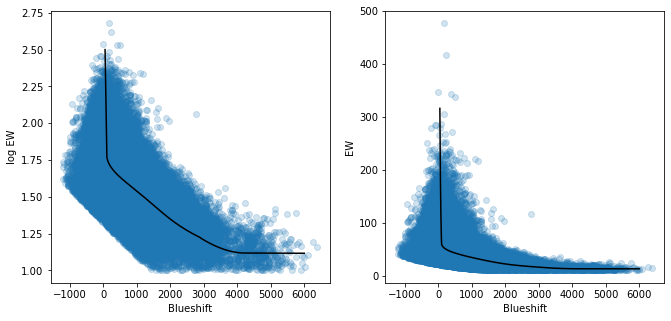

In [9]:
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(11,5))

ax1.scatter(blue[good], logEW[good], alpha=0.2)
ax1.plot(fit[:,0], fit[:,1], "-k")
#ax1.set_xlim(-1800, 6800)
ax1.set_xlabel("Blueshift")
ax1.set_ylabel("log EW")

ax2.scatter(blue[good], EW[good], alpha=0.2)
ax2.plot(fit[:,0], 10.**fit[:,1], "-k")
#ax2.set_xlim(-1800, 6800)
ax2.set_xlabel("Blueshift")
ax2.set_ylabel("EW")

plt.show()

In [10]:
#Build saveable "scale" models based 
scale_linear = MinMaxScaler().fit(c4data_lin[good&(c4data_lin[:,1]<300)]) #set 1 to lower than max(EW)
scale_log = MinMaxScaler().fit(c4data_log[good[mask]])

c4data_linear_scale = scale_linear.transform(c4data_lin[good])
c4data_log_scale = scale_log.transform(c4data_log[good[mask]])

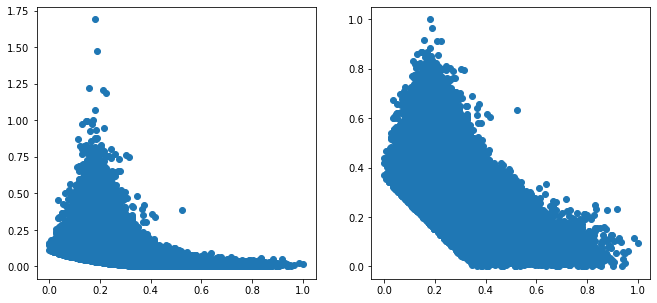

In [11]:
#See what the scaled data look like
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(11,5))
ax1.scatter(c4data_linear_scale[:,0], c4data_linear_scale[:,1])
ax2.scatter(c4data_log_scale[:,0], c4data_log_scale[:,1])
plt.show()

Good, this works.  Now save the model and will change the lines in ``CIV_distance()`` that do the scaling to loading in this scaling model.

In [12]:
import joblib
joblib.dump(scale_linear,"../CIV_Distance/scalers/scaler_linEW.save")
joblib.dump(scale_log,"../CIV_Distance/scalers/scaler_logEW.save")

['../CIV_Distance/scalers/scaler_logEW.save']

With the log fit, points don't bunch up as much at the bend of the curve, so the CIV disance becomes more meaningful fo quasars with low EWs and negative blueshifts.

In [13]:
c4dist_lin = CIV_distance(c4data_lin, fit, step=10, logEW=False) #compute CIV distances like this
print("Done linear")

c4dist_log = CIV_distance(c4data_log, fit, step=10)
print("Done log")

Done linear
Done log


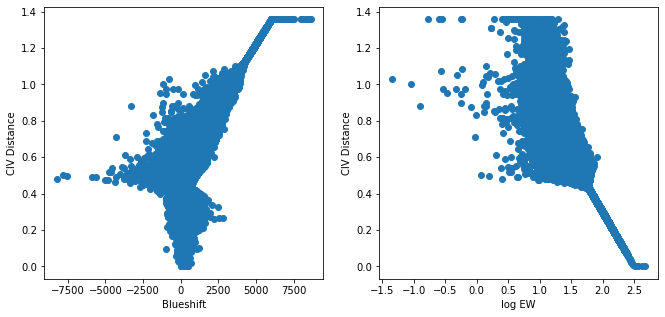

In [14]:
#Why is Gordon's peak at ~2.5 and mine at ~4??  Honestly makes no sense to me... 
#UPDATE: This is fixed - I saved a scaler model and we can use that on any input dataset


fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(11,5))

ax1.scatter(blue[mask], c4dist_log)
ax1.set_xlabel("Blueshift")
ax1.set_ylabel("CIV Distance")

ax2.scatter(logEW[mask], c4dist_log)
ax2.set_xlabel("log EW")
ax2.set_ylabel("CIV Distance")

plt.show()

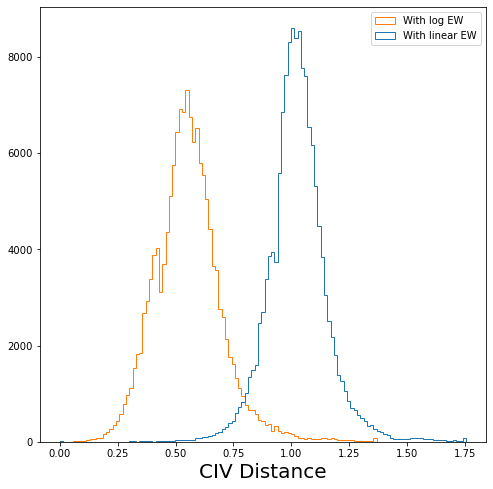

In [15]:
fig = plt.figure(figsize=(8,8))
plt.hist([c4dist_lin, c4dist_log], histtype="step", bins="scott", label=["With linear EW", "With log EW"])
plt.xlabel("CIV Distance", fontsize=20)
plt.legend(loc="best")
plt.show()

Is that second peak in the distribution coincidental or worth looking into?  Two populations of quasars?  Might just have something to do with the "bend"

In [16]:
import joblib

fit_lin = fit.copy()
fit_lin[:,1] = 10.**fit_lin[:,1]
scaler_lin = joblib.load("scalers/scaler_linEW.save")
c4data_lin_scale = scaler_lin.transform(c4data_lin)
bestfit_lin_scale = scaler_lin.transform(fit_lin)

fit_log = fit.copy()
scaler_log = joblib.load("scalers/scaler_logEW.save")
c4data_log_scale = scaler_log.transform(c4data_log)
bestfit_log_scale = scaler_log.transform(fit_log)

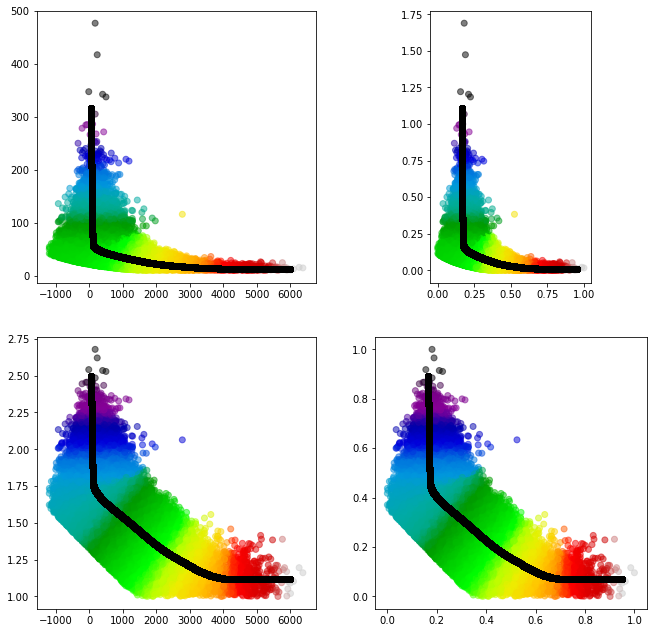

In [17]:
fig, [[ax1,ax2],[ax3,ax4]] = plt.subplots(2, 2, figsize=(11,11))

ax1.scatter(blue[good], EW[good], alpha=0.5, c=c4dist_lin[good], cmap="nipy_spectral")
ax1.scatter(fit_lin[:,0], fit_lin[:,1], c="k")
#ax1.set_ylim(-7,300)

ax2.scatter(c4data_lin_scale[good,0], c4data_lin_scale[good,1], alpha=0.5, c=c4dist_lin[good], cmap="nipy_spectral")
ax2.scatter(bestfit_lin_scale[:,0], bestfit_lin_scale[:,1], c="k")
ax2.set_aspect("equal")
#ax2.set_ylim(-1.5,4.5)

ax3.scatter(blue[mask][good[mask]], logEW[mask][good[mask]], alpha=0.5, c=c4dist_log[good[mask]], cmap="nipy_spectral")
ax3.scatter(fit_log[:,0], fit_log[:,1], c="k")
#ax3.set_ylim(-7,300)

ax4.scatter(c4data_log_scale[good[mask],0], c4data_log_scale[good[mask],1], alpha=0.5, c=c4dist_log[good[mask]], cmap="nipy_spectral")
ax4.scatter(bestfit_log_scale[:,0], bestfit_log_scale[:,1], c="k")
ax4.set_aspect("equal")
#ax4.set_ylim(-1.5,4.5)

plt.show()

In [18]:
#Save the scaled data
np.save("Gordons_Xray_data/CIV_amy_scaled_linear.npy", c4data_lin_scale)
np.save("Gordons_Xray_data/CIV_amy_scaled_log.npy", c4data_log_scale)

---- 

Find some points with given CIV distances on each scale.

In [19]:
def find_distance(c4dist, val, tol=0.01):
    return np.abs(c4dist-val)<tol

for i in np.arange(1, 30+1, 1):
    globals()['lindist_%s' % i] = find_distance(c4dist_lin, i/20, 0.008)

for i in np.arange(1, 18+1, 1):
    globals()['logdist_%s' % i] = find_distance(c4dist_log, i/12, 0.008)

In [20]:
EW[lindist_1], EW[mask][logdist_1]

(array([], dtype=float64),
 array([229.60513327, 232.38711748, 228.18481704, 229.92884717,
        229.193157  , 235.60952364, 223.93617842, 227.84942455,
        231.43251092, 233.23342762, 222.56994508, 225.92323895,
        231.44199397, 223.15733136, 226.19000176, 235.40879948,
        228.70277525, 228.2019757 , 226.07422592, 231.50924239,
        226.48869842, 227.96463626, 225.48553684]))

In [21]:
c4dist_lin[eval('lindist_1')]

array([], dtype=float64)

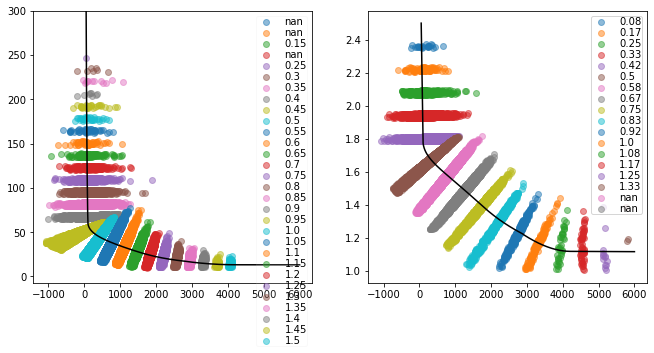

In [22]:
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(11,5))

for i in range(30):
    ax1.scatter(blue[eval("lindist_%d"%(i+1))&good], EW[eval("lindist_%d"%(i+1))&good], alpha=0.5, label=round(c4dist_lin[eval("lindist_%d"%(i+1))].mean(), 2))
ax1.plot(fit_lin[:,0], fit_lin[:,1], c="k")
ax1.set_ylim(-7,300)
ax1.legend(loc="best", framealpha=0.1, borderpad=0.05, labelspacing=0.1)

for i in range(18):
    ax2.scatter(blue[mask][eval("logdist_%d"%(i+1))&good[mask]], logEW[mask][eval("logdist_%d"%(i+1))&good[mask]], alpha=0.5, label=round(c4dist_log[eval("logdist_%d"%(i+1))].mean(), 2))
ax2.plot(fit_log[:,0], fit_log[:,1], c="k")
#ax2.set_ylim(-7,300)
ax2.legend(loc="best", borderpad=0.05, labelspacing=0.1)

plt.show()

nan just means we didn't find any data within some tolerance to the given value.